In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

connection = {'host': 'hidden_host',
                      'database':'hidden_database',
                      'user':'hidden_user', 
                      'password':'hidden_password'
                     }


In [2]:
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-21' and '2022-09-27'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,1,109963,2,20,0.100000
1,1,138232,21,109,0.192661
2,1,49286,10,64,0.156250
3,1,145957,24,62,0.387097
4,2,131473,22,80,0.275000
...,...,...,...,...,...
26962,1,132567,11,56,0.196429
26963,1,30872,8,27,0.296296
26964,2,25383,7,40,0.175000
26965,1,57001,4,33,0.121212


Посмотрим распределение пользователей по группам:

In [3]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,13553,13553,13553,13553
2,13414,13414,13414,13414


В каждой из групп количество пользователей примерно **равное**. Посмотрим наглядно на распределение целевой метрики каждой группы.

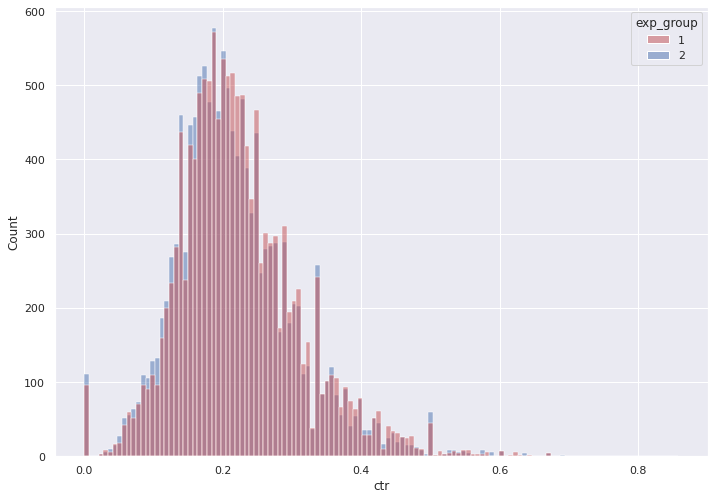

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

Видно, что распределение в двух группах сильно различается. В экспериментальной группе распределение целевой метрики поменяло форму и стало двугорбым.

---

Проведем t test и тест Манна Уитни. В первом случае нулевой гипотезой является равенство средних. Во втором нулевая гипотеза о равенство вероятности преобладания одного элемента из группы 1 над элементом из группы 2.

In [5]:
stats.ttest_ind(df.query('exp_group == 1').ctr,
                df.query('exp_group == 2').ctr,
                equal_var=False)

Ttest_indResult(statistic=4.826579789306613, pvalue=1.3965740773012885e-06)

In [6]:
stats.mannwhitneyu(df.query('exp_group == 1').ctr, 
                   df.query('exp_group == 2').ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=94389201.0, pvalue=4.788319445221499e-08)

T-test показывает отсутсвие отличий между группами. Значение pvalue не позволяет отклонить нулевую гипотезу о равенстве средних.
А тест Манна-Уитни в свою очередь видит значимое различие.

---

Проверим отличия на сглаженном CTR


In [7]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [8]:
global_ctr_1 = df.query('exp_group == 1').likes.sum()/df.query('exp_group == 1').views.sum()
global_ctr_2 = df.query('exp_group == 2').likes.sum()/df.query('exp_group == 2').views.sum()

In [9]:
group1 = df.query('exp_group == 1').copy()
group2 = df.query('exp_group == 2').copy()

In [10]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

Построим графики сглаженного CTR по группам и сделаем T-test.

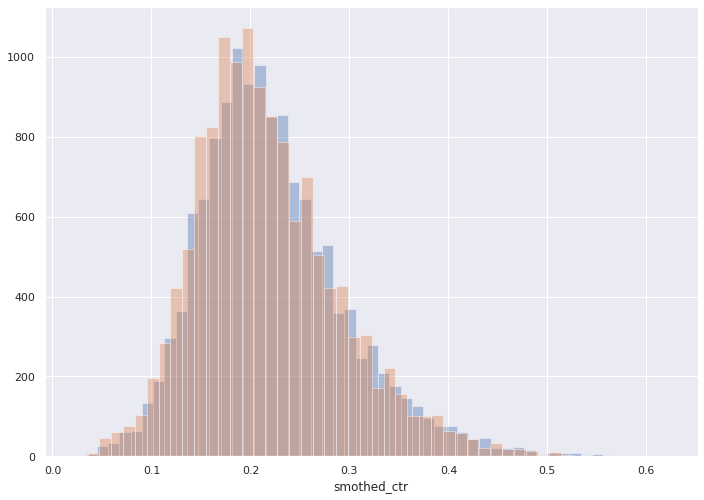

In [11]:
sns.distplot(group1.smothed_ctr, 
             kde = False,
            bins = 50)
sns.distplot(group2.smothed_ctr, 
             kde = False,
            bins = 50)
plt.show()

In [12]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=5.866997001157933, pvalue=4.489392502575877e-09)

Тест видит отличия между группами по сглаженному CTR.  Значение pvalue позволяет отклонить нулевую гипотезу, но у нас нет теоретических гарантий о сонаправленности с общим количеством лайков.


---


Пуассоновский бутстреп

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [14]:
likes1 = df.query('exp_group == 1').likes.to_numpy()
views1 = df.query('exp_group == 1').views.to_numpy()
likes2 = df.query('exp_group == 2').likes.to_numpy()
views2 = df.query('exp_group == 2').views.to_numpy()

ctr1, ctr2 = tqdm(bootstrap(likes1, views1, likes2, views2))


100%|██████████| 2/2 [00:00<00:00, 14364.05it/s]


Построим получившиеся распределения.

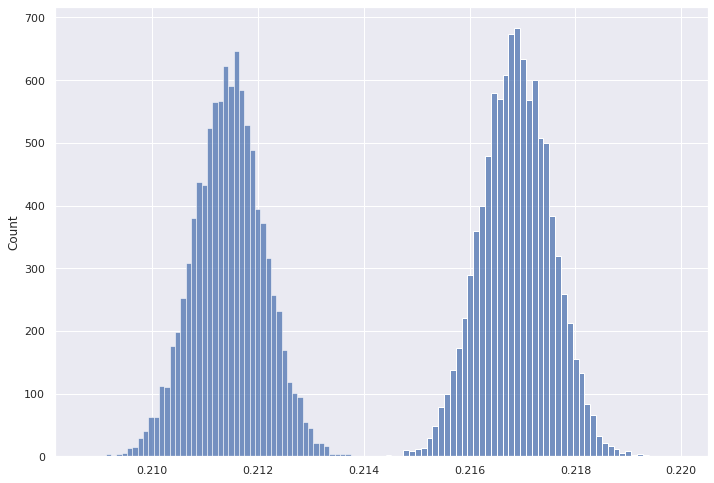

In [15]:
sns.histplot(ctr1, bins = 50)
sns.histplot(ctr2, bins = 50)
plt.show()

По результатам бутстрепа значение искомой метрики в экспериментальной группе значимо хуже, чем в контрольной. Посмотрим наглядно на распределение разницы глобальных CTR.

<AxesSubplot:ylabel='Count'>

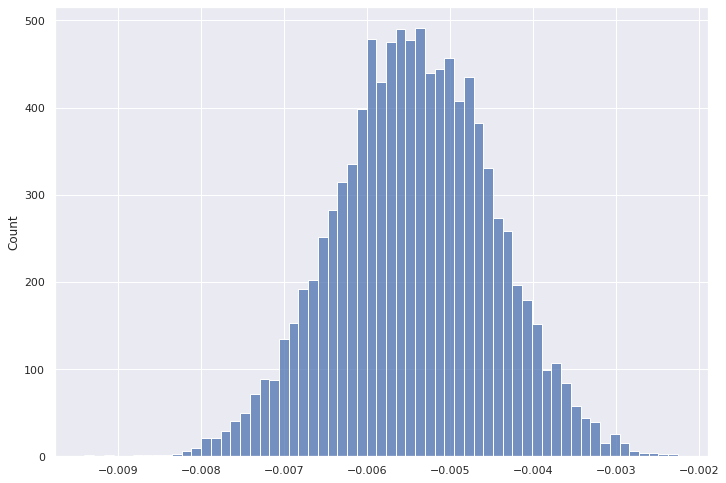

In [16]:
sns.histplot(ctr2 - ctr1)

Так как распределение имеет орицательные значения, можно утверждать что в контрольной группе общегрупповой CTR стал ниже чем в контрольной.

---

Проведем T-тест и тест Манна-Уитни поверх бакетного преобразования. И построим график распределения бакетного CTR.

In [17]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-09-21' and '2022-09-27'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = ph.read_clickhouse(q, connection=connection)


In [18]:
stats.ttest_ind(df_bucket.query('exp_group == 1').bucket_ctr,
                df_bucket.query('exp_group == 2').bucket_ctr,
                equal_var = False)

Ttest_indResult(statistic=5.350467014452549, pvalue=5.836286882355174e-07)

In [19]:

stats.mannwhitneyu(df_bucket.query('exp_group == 1').bucket_ctr,
                   df_bucket.query('exp_group == 2').bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1991.0, pvalue=3.3101566503929746e-07)

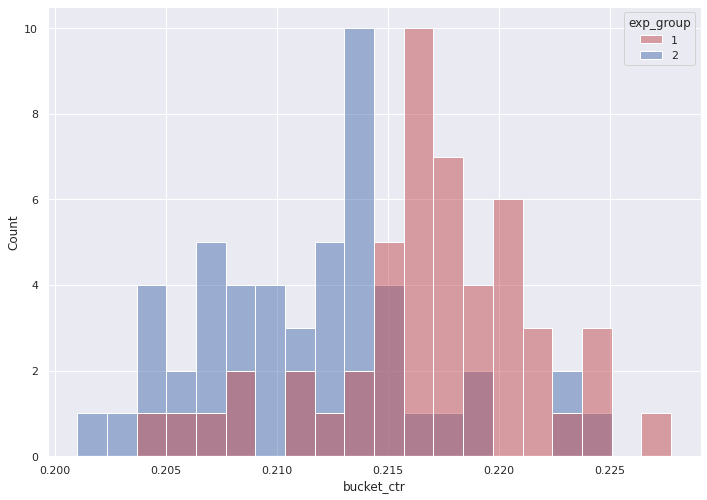

In [20]:
sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
             bins = 20)
plt.show()

Оба теста поверх бакетного преобразование видят значимые различия. На визуализации бакетного распределения эти отличия также заметны.

---

### Вывод:

Из-за того, что распределение целевой метрики в экспериментальной группе стало двугорбым, T-test **не видел** отличия в двух группах. И только путем различных преобразований `CTR`, удалось выявить значимые различия в двух группах. 
Раскатывать новый алгоритм на всех пользователей **не стоит**. Общегрупповой `CTR` в экспериментальной группе стал **хуже**, чем в контрольной.
В экспериментальной группе появились пользователи, у которых `CTR` стал меньше, но появились и те, у кого `CTR` стал существенно больше. Стоит обратить на это внимание и возможно выяснить обстоятельства для каких пользователей новый алгоритм рекомендаций сработал, а для каких нет. Это позволит доработать алгоритм и уже можно будет провести тест повторно, на обновленном алгоритме.